# Modelo de usuarios casuales

In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_pickle("data/procesados_casual.pkl")
df.head(1)

,fecha,estacion,año,mes,festivo,dia_semana,clima,temperatura,humedad,viento,casual,casual_box,laboral_no,laboral_sí
0,2018-01-01,0.0,0,0,0,1.0,1,-0.82907,1.268831,-0.212121,331,16.39782,1.0,0.0


In [4]:
df.drop(["fecha", "casual_box"], axis = 1, inplace = True)

In [5]:
# Separamos en X e y.
X = df.drop("casual", axis = 1)
y = df["casual"]

In [6]:
# Separamos en train y test.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# Instanciamos el método

arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

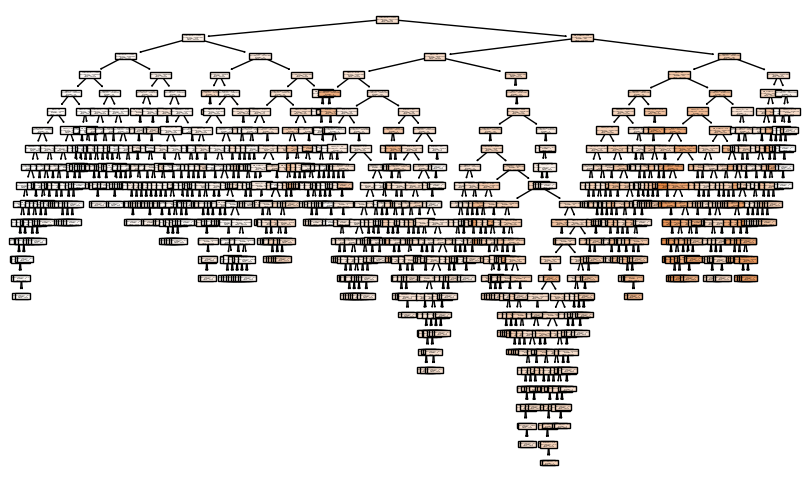

In [8]:
fig = plt.figure(figsize = (10,6))

tree.plot_tree(arbol, feature_names = (x_train.columns).tolist(), filled = True)

plt.show()

In [9]:
# Hacemos las predicciones

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [10]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """
Esta función nos saca las métricas de nuestro modelo a predecir.
Args: 
    y_test(serie): los datos que tenemos.
    y_train(serie): los datos que ha predicho.
    y_test_pred(serie): los datos que tenemos.
    y_train_pred(serie): los datos que ha predicho.
    tipo_modelo(string): nombre que le damos a nuestro modelo.
Returns: devuelve un dataframe con las métricas.
    """   
    resultados = {"MAE": [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                "MSE": [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                "RMSE": [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                "R2":  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [11]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,413.205479,349397.369863,591.098443,0.272731,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I


Como podemos apreciar en estas métricas, nos encontramos ante un claro caso de overfitting, ya que las métricas de train son perfectas, y test tiene métricas mucho peores. Por tanto, vamos a ajustar los hiperparámetros. 

In [12]:
# Sacamos el cuadrado del número de columnas de train.
max_features = np.sqrt(len(x_train.columns))
max_features

3.3166247903554

In [13]:
# Sacamos la máxima profundidad de nuestro árbol.
print(arbol.tree_.max_depth)

24


In [14]:
# Ajustamos los parámetros.

parametros = {"max_depth": [10,12], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [2,3,4], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [50, 100]}

In [15]:
# Una vez creado el diccionario iniciamos el modelo con GridSearch.

gs_dt1 = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = parametros,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
            scoring = "neg_mean_squared_error") 

In [16]:
gs_dt1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 12], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
mejor_arbol1 = gs_dt1.best_estimator_ 
mejor_arbol1

DecisionTreeRegressor(max_depth=10, max_features=4, min_samples_leaf=50,
                      min_samples_split=50)

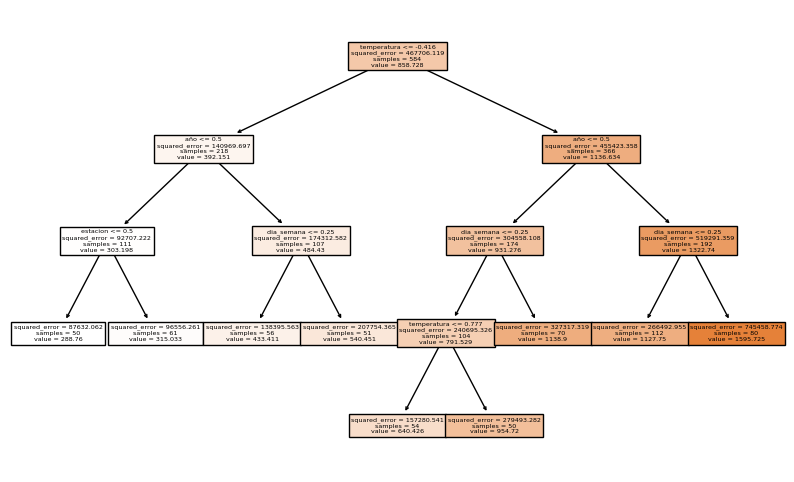

In [18]:
fig = plt.figure(figsize = (10,6))

tree.plot_tree(mejor_arbol1, feature_names = (x_train.columns).tolist(), filled = True)

plt.show()

In [19]:
y_pred_test_dt2 = mejor_arbol1.predict(x_test)
y_pred_train_dt2 = mejor_arbol1.predict(x_train)

In [20]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,344.932906,224534.920502,473.851159,0.532632,test,Decision tree II
1,382.885857,279933.386591,529.087315,0.401476,train,Decision tree II


No nos han salido buenos resultados, vamos a modificar los parámetros.

In [21]:
parametros2 = {"max_depth": [6, 8, 10,12], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [1, 2, 3, 4, 5], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [10, 25, 50],
        "min_samples_leaf": [5, 10, 25]}

In [22]:
gs_dt2 = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = parametros2,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
            scoring = "neg_mean_squared_error") 

In [23]:
gs_dt2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10, 12],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 25],
                         'min_samples_split': [10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
mejor_arbol2 = gs_dt2.best_estimator_ 
mejor_arbol2

DecisionTreeRegressor(max_depth=10, max_features=5, min_samples_leaf=10,
                      min_samples_split=10)

In [25]:
y_pred_test_dt3 = mejor_arbol2.predict(x_test)
y_pred_train_dt3 = mejor_arbol2.predict(x_train)

In [26]:
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,333.662527,241241.192424,491.163102,0.497858,test,Decision tree III
1,284.874191,180747.647472,425.144267,0.613544,train,Decision tree III


Nos han mejorado los resultados, pero siguen sin ser del todo buenos.

In [27]:
parametros3 = {"max_depth": [4, 5, 6, 7], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [4, 5, 6, 7], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [5, 10, 25, 50],
        "min_samples_leaf": [2.5, 5, 10, 25]}

In [28]:
gs_dt3 = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = parametros3,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
            scoring = "neg_mean_squared_error") 

In [29]:
gs_dt3.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [2.5, 5, 10, 25],
                         'min_samples_split': [5, 10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
mejor_arbol3 = gs_dt3.best_estimator_ 
mejor_arbol3

DecisionTreeRegressor(max_depth=7, max_features=7, min_samples_leaf=10,
                      min_samples_split=25)

In [31]:
y_pred_test_dt4 = mejor_arbol3.predict(x_test)
y_pred_train_dt4 = mejor_arbol3.predict(x_train)

In [32]:
dt_results4 = metricas(y_test, y_train, y_pred_test_dt4, y_pred_train_dt4, "Decision tree IV")
dt_results4

,MAE,MSE,RMSE,R2,set,modelo
0,327.284672,207541.155298,455.566851,0.568004,test,Decision tree IV
1,298.309567,187055.462914,432.499090,0.600058,train,Decision tree IV


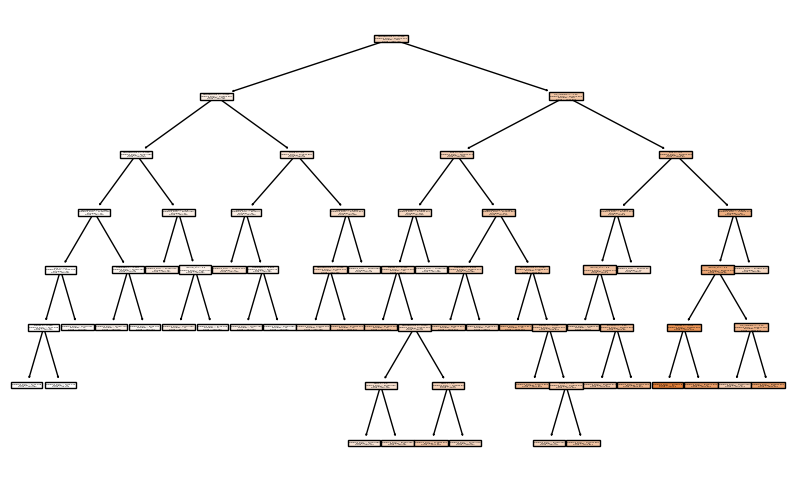

In [33]:
fig = plt.figure(figsize = (10,6))

tree.plot_tree(mejor_arbol3, feature_names = (x_train.columns).tolist(), filled = True)

plt.show()

Siguen sin salir buenas métricas, pasamos a reaizar un *Random Forest*.

In [34]:
gs_rf = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros3, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [35]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [2.5, 5, 10, 25],
                         'min_samples_split': [5, 10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=7, max_features=5, min_samples_leaf=5,
                      min_samples_split=10)

In [37]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [38]:
df_resultados3 = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest I")
df_resultados3

,MAE,MSE,RMSE,R2,set,modelo
0,295.018846,173583.501083,416.633533,0.638687,test,Random Forest I
1,262.516076,138562.089164,372.239290,0.703741,train,Random Forest I


In [39]:
df_resultados_total = pd.concat(dt_results1, dt_results2, dt_results3, dt_results4, df_resultados3)
df_resultados_total

TypeError: concat() takes 1 positional argument but 5 were given